# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 4
This notebook reproduces the figures from poster panel 4. Panel 4 investigates the relationship between spike-synchrony and aperiodic LFP activity. Comparisons are made between behavioral epochs.

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sts
import statsmodels.api as sm
import os

In [4]:
# custom imports
import sys
sys.path.append('../../')
from allen_vc.plots import plot_regression_line
from allen_vc.utils import knee_freq
from allen_vc.stats import mixedLM


print("Imported!")

Imported!


### settings

In [5]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### function

In [6]:
def create_long_region_df(df, suffix_metrics, merge_on):
    """Create long-format dataframe for plotting. Combine metrics for each region.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing metrics for each region.
    suffix_metrics : list
        List of metrics with different values for each region. 
        These will be appended with the region name.
    merge_on : str
        Column name to merge on (in addition to 'session' and 'epoch_idx').

    Returns
    -------
    df : pd.DataFrame
        Long-format dataframe.
    """

    v = df.loc[df['brain_structure'] == 'VISp']
    metrics = ['session', 'epoch_idx', merge_on] + suffix_metrics
    l = df.loc[df['brain_structure'] == 'LGd', metrics]
    df = v.merge(l, on=['session', 'epoch_idx', merge_on], suffixes=('_VISp', '_LGd'))
        
    return df

In [7]:

from matplotlib.pyplot import xlabel


def plot_linregress(df, x_var, y_var, group=None, multireg=False, singlereg=False, legend=True, title='', 
                    print_stats=False, fname_out=None, show=False, close=False, scatter_alpha=0.6, colors=None,
                    x_label=None, y_label=None):
    """
    Calculate and plot the linear regression of two columns in a dataframe.

    Parameters
    ----------
    x_var : str
        column with x-values of dataset
    y_var : str
        column with y-values of dataset
    group: str, optional
        column to color/section data by.
    multireg: bool, optional
        whether or not to plot regression lines for each group
    singlereg: bool, optional
        whether or not to plot a single regression line for all data
    legend: bool, optional
        whether or not to include a legend
    title: str, optional
        title of the figure
    print_stats: bool, optional
        whether or not to print regression statistics
    fname_out : str, optional
        Filename of the output figure
    show : bool, optional
        Whether to show the figure or not
    close : bool, optional
        Whether to close the figure or not
    scatter_alpha : float, optional
        Alpha value for scatter points
    colors : list, optional
        List of colors to use for each group

    Returns
    -------
    None
    """
    
    # create figure
    fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
    fig.patch.set_facecolor('white') # set background color to white for text legibility
    markers = ['.', 'v']
    colors = ['C0', 'C1', 'C2', 'C3'] if colors is None else colors
    
    # plot data
    c = 0
    for r, region in enumerate(df['brain_structure'].unique()):
        region_df = df[df['brain_structure'] == region]

        if group is not None:
            groups = region_df[group].unique()
            for i, g in enumerate(groups):
                gdf = region_df[region_df[group] == g]
                ax.scatter(gdf[x_var], gdf[y_var], label=region + ' ' + g, 
                    alpha=scatter_alpha, marker=markers[r], color=colors[c])

                if multireg:
                    # run regression and plot results
                    if print_stats:
                        plot_regression_line(gdf[x_var], gdf[y_var], ax=ax, 
                            text_height=0.9-r*0.4-i*0.2, label=region + ' ' + g, color=colors[c])
                    else:
                        plot_regression_line(gdf[x_var], gdf[y_var], ax=ax, 
                            print_stats=False, color=colors[c])
                    c += 1

            if singlereg:
                if print_stats:
                    plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                            text_height=0.9-r*0.4, label=region, color='black')
                else:
                    plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                            print_stats=False, color='black')

        else:
            ax.scatter(region_df[x_var], region_df[y_var], label=region, 
                alpha=scatter_alpha, color=colors[c])

            # run regression and plot results
            if print_stats:
                plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                    text_height=0.9-r*0.2, label=region, color=colors[c])
            else:
                plot_regression_line(region_df[x_var], region_df[y_var], ax=ax, 
                    print_stats=False, color=colors[c])
            c += 1


    # label figure
    if legend:
        ax.legend(loc='lower right')
    plt.title(title)
    if xlabel is None:
        plt.xlabel(x_var.replace('_',' '))
    else:
        plt.xlabel(x_label)
    if y_label is None:
        plt.ylabel(y_var.replace('_',' '))
    else:
        plt.ylabel(y_label)
                
    # save/show figure
    if not fname_out is None:
        fig.savefig(fname_out)
    if show:
        plt.show()
    if close:
        plt.close()

### load data

In [8]:
# load data for beahvior: running

# load spike data
running_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_running.csv').assign(behavior='running')

# load lfp data
running_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_running/lfp_params.csv')


In [9]:
# load data for beahvior: stationary

# load spike data
stationary_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_stationary.csv').assign(behavior='stationary')

# load lfp data
stationary_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_stationary/lfp_params.csv')


In [10]:
# load data for stim: natural_movie_one_more_repeats

# load spike data
movie_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_more_repeats.csv').assign(presentation='movie')

# load lfp data
movie_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_more_repeats/lfp_params.csv')


In [11]:
# load data for stim: natural_movie_one_shuffled

# load spike data
shuffled_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_shuffled.csv').assign(presentation='shuffled')

# load lfp data
shuffled_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_shuffled/lfp_params.csv')


In [12]:
stationary_spikes.head()

,session,brain_structure,epoch_idx,epoch_times,running,region_cv,spike_distance,spike_synchrony,mean_firing_rate,mean_fano_factor,mean_cv,behavior
0,847657808,VISp,0,"[4427.179999999999, 4457.179999999999]",False,1.142944,0.175098,0.368898,6.880667,3.890117,NaN,stationary
1,847657808,VISp,1,"[4457.179999999999, 4487.179999999999]",False,1.651468,0.156556,0.362379,5.345333,2.677611,NaN,stationary
2,847657808,VISp,2,"[4487.179999999999, 4517.179999999999]",False,1.247455,0.161036,0.361407,5.810667,3.422639,NaN,stationary
3,847657808,VISp,3,"[4517.179999999999, 4547.179999999999]",False,1.459936,0.158529,0.363238,5.158667,NaN,[nan nan],stationary
4,847657808,VISp,4,"[4547.179999999999, 4577.179999999999]",False,1.696631,0.152400,0.359005,5.196667,3.200331,NaN,stationary


In [13]:
stationary_lfp.head()


,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,chan_idx,epoch_idx,session
0,-3.771667,245.885669,2.493447,56.955605,0.250228,20.000000,59.918071,0.317078,2.000000,88.793669,0.294039,2.000000,111.829713,0.157798,20.0,0.081832,0.986180,0,0,766640955
1,-3.954541,192.355019,2.416571,8.156027,0.225060,5.204005,48.066667,0.193746,15.415618,57.025346,0.318765,5.251163,63.400000,0.201063,20.0,0.078450,0.987551,1,0,766640955
2,-4.049800,199.223543,2.362755,8.116516,0.266084,5.489826,51.109491,0.287244,2.000000,54.728983,0.398060,2.000000,58.021375,0.239160,20.0,0.077041,0.987167,2,0,766640955
3,-3.987350,158.973247,2.420144,50.874380,0.294866,2.000000,55.053568,0.420922,3.047117,59.647910,0.364857,2.000000,62.733333,0.185731,20.0,0.080944,0.986198,3,0,766640955
4,-4.026376,92.219677,2.395353,50.806531,0.277462,2.000000,55.599667,0.382403,5.667297,63.725146,0.200856,20.000000,190.415458,0.324892,2.0,0.081736,0.986071,4,0,766640955


## Main

### Regression plot: mean firing rate vs. broadband offset 

##### Spontaneous activity: model behavioral states (running and stationary) seperately  

In [14]:
# modify df_lfp - average over channels for each epoch within each session
running_lfp_i = running_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(behavior='running')
stationary_lfp_i = stationary_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(behavior='stationary')

# concatenate running and stationary epoch data
lfp_i = pd.concat([running_lfp_i, stationary_lfp_i])
units_i = pd.concat([running_spikes, stationary_spikes])

# merge lfp and spike data
nan_i = lfp_i.merge(units_i, on=['session', 'epoch_idx', 'behavior'])

# drop nan
behavior_df = nan_i.dropna(subset=['offset'])
print(f'Number of rows after dropping NaNs: {len(nan_i)-len(behavior_df)}')

Number of rows after dropping NaNs: 12


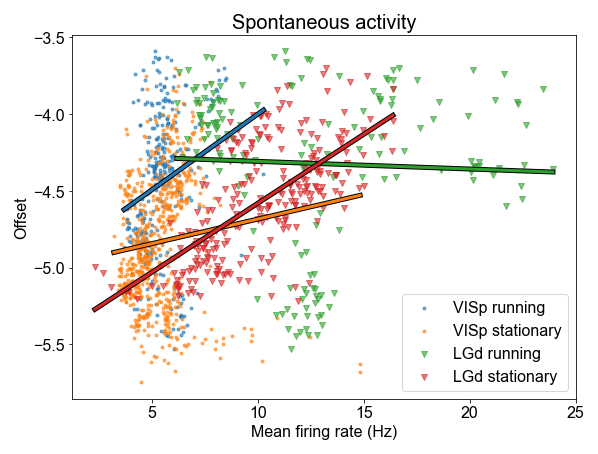

In [15]:
plot_linregress(behavior_df, 'mean_firing_rate', 'offset', group='behavior', 
                title='Spontaneous activity', multireg=True, show=False, print_stats=False,
                x_label='Mean firing rate (Hz)', y_label='Offset')


In [16]:
# # remove clear outlier
# behavior_df = behavior_df_i[behavior_df_i['mean_firing_rate'] > 0.01]

# plot_linregress(behavior_df, 'mean_firing_rate', 'offset', group='behavior', multireg=True, show=True)

##### Passive viewing: model stimulus contexts (movie and shuffled) seperately; plot stationary epochs only

In [17]:
# modify df_lfp - average over channels for each epoch within each session
movie_lfp_i = movie_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='movie')
shuffled_lfp_i = shuffled_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='shuffled')

# concatenate movie and shuffled epoch data
lfp_i = pd.concat([movie_lfp_i, shuffled_lfp_i])
units_i = pd.concat([movie_spikes, shuffled_spikes])

# merge lfp and spike data
nans_i = lfp_i.merge(units_i, on=['session', 'epoch_idx', 'presentation'])

# drop nan
presentation_df = nans_i.dropna(subset=['offset'])
print(f'Number of rows after dropping NaNs: {len(nans_i)-len(presentation_df)}')

Number of rows after dropping NaNs: 4


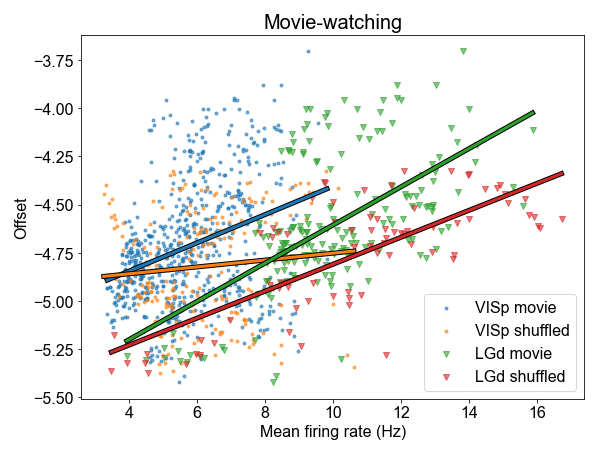

In [18]:
# section stationary epochs only for now
stationary_presentation_df = presentation_df[~presentation_df['running']] # stationary epochs only
plot_linregress(stationary_presentation_df, 'mean_firing_rate', 'offset', group='presentation', 
                title='Movie-watching', multireg=True, show=True,
                x_label='Mean firing rate (Hz)', y_label='Offset')

In [19]:
# plot each condition seperately

# # loop through stimuli
# for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
#                                       [movie_lfp, shuffled_lfp],
#                                       [movie_spikes, shuffled_spikes]):
#     # modify df_lfp - average over channels for each epoch within each session
#     df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

#     # FIX: remove space from brain structure names
#     df_units['brain_structure'] = df_units['brain_structure'].str.replace(' ', '')

#     # loop through spiking region
#     for spike_region in ['VISp', 'LGd']:
#         # get unit data for this region
#         df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

#         # merge unit and lfp dataframes
#         df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

#         # loop through behavioral conditions
#         for behavior, running in zip(['running', 'stationary'], [True, False]):

#             # filter df by behavior
#             df = df_i[df_i.get('running')==running]
            
#             # plot each session
#             sessions = df.get('session').unique()
#             fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
#             fig.patch.set_facecolor('white')
#             for ses in sessions:
#                 ses_df = df[df.get('session')==ses]

#                 # plot each epoch
#                 sc =  ax.scatter(ses_df.get('mean_firing_rate'), 
#                                  ses_df.get('offset'), label=ses)

#                 # plot session mean
#                 ax.scatter(ses_df.get('mean_firing_rate').mean(), 
#                            ses_df.get('offset').mean(), color=sc.get_facecolors()[0], s=100)
#                 sc.set_alpha(0.5)
                
#             # run regression across all epochs and plot results
#             df_avg = df.groupby(['session']).mean().reset_index()# average across trials
#             x_data = df_avg.get('mean_firing_rate')
#             y_data = df_avg.get('offset')
#             results = sts.linregress(x_data, y_data)
#             l1 = np.linspace(min(x_data), max(x_data), 1000)
#             t1 = results.slope * l1 + results.intercept
#             ax.plot(l1, t1, color='k', linewidth=3)

#             # add regression results text
#             if results.pvalue < 0.001:
#                 pval = f"{results.pvalue:.2e}"
#             else:
#                 pval = f"{results.pvalue:.3f}"
#             plt.text(1.05, 0.9, 
#                     f"Linear regression:\n" +
#                     f"    Slope: {results.slope:.3f}\n" +
#                     f"    Intercept: {results.intercept:.3f}\n" +
#                     f"    R: {results.rvalue:.3f}\n" +
#                     f"    p: {pval}", transform = ax.transAxes)

#             # label
#             # ax.legend(bbox_to_anchor=(1.05, -.1), loc='lower left', borderaxespad=0.)
#             plt.xlabel("mean firing rate (Hz)")
#             plt.ylabel("broadband offset")
#             plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
#             # save
#             dir_figures = f"{PROJECT_PATH}/figures/offset_vs_rate/{spike_region}/{behavior}"
#             # plt.savefig(f"{dir_figures}/all_sessions")

### Regression plot: SPIKE-distance vs. LFP exponent 

##### Spontaneous activity: model behavioral states (running and stationary) seperately  

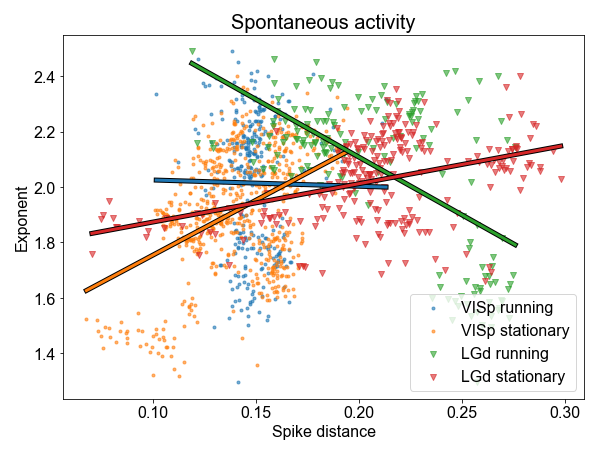

In [20]:
plot_linregress(behavior_df, 'spike_distance', 'exponent', group='behavior', 
                title='Spontaneous activity', multireg=True, show=True,
                x_label='Spike distance', y_label='Exponent')

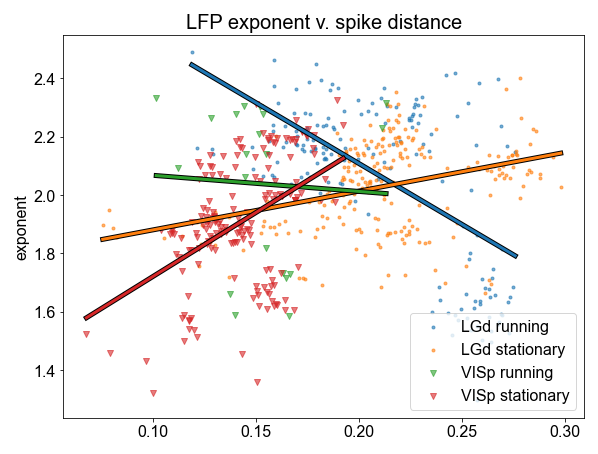

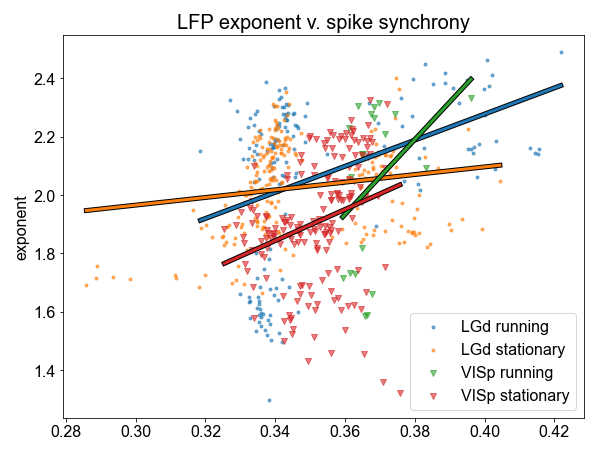

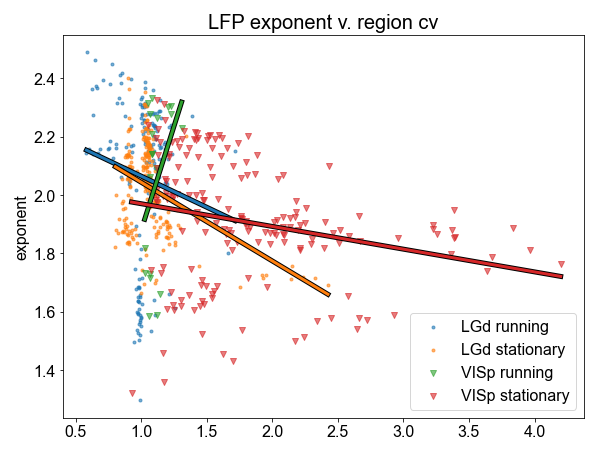

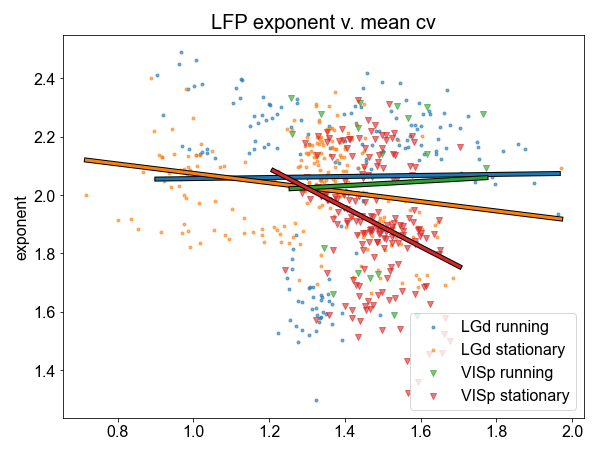

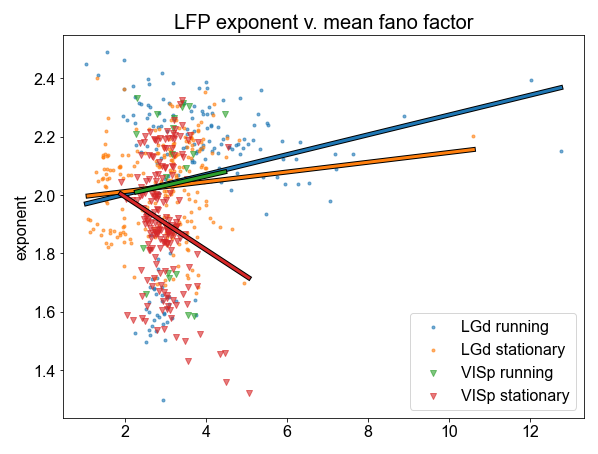

In [21]:
# plot each regional synchrony metric
behavior_df_c = behavior_df.dropna()
behavior_df_c = behavior_df_c.astype({'region_cv':'float', 'mean_cv':'float'})
for var in ['spike_distance', 'spike_synchrony', 'region_cv', 'mean_cv', 'mean_fano_factor']:
    plot_linregress(behavior_df_c, var, 'exponent', group='behavior', multireg=True, show=False)
    ax = plt.gca()
    ax.set_title(f"LFP exponent v. {var.replace('_', ' ')}")
    plt.show()

##### Passive viewing: model stimulus contexts (movie and shuffled) seperately; plot stationary epochs only

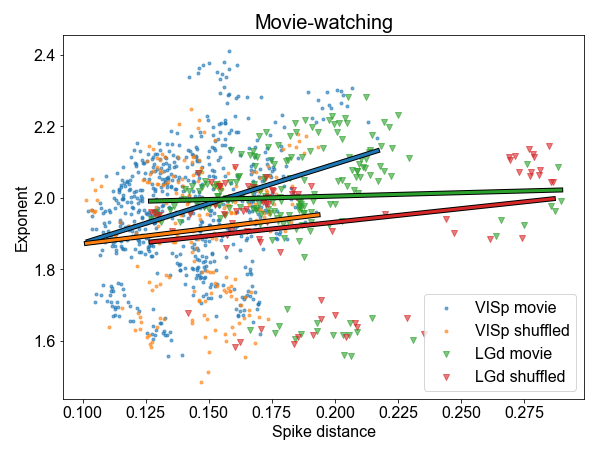

In [22]:
stationary_presentation_df = presentation_df[~presentation_df['running']]
plot_linregress(stationary_presentation_df, 'spike_distance', 'exponent', group='presentation',
                title='Movie-watching', multireg=True, show=True,
                x_label='Spike distance', y_label='Exponent')

In [23]:
# # plot each condition seperately

# # loop through stimuli
# for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
#                                       [movie_lfp, shuffled_lfp],
#                                       [movie_spikes, shuffled_spikes]):
#     # modify df_lfp - average over channels for each epoch within each session
#     df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

#     # loop through spiking region
#     for spike_region in ['VISp', 'LGd']:
#         # get unit data for this region
#         df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

#         # merge unit and lfp dataframes
#         df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

#         # loop through behavioral conditions
#         for behavior, running in zip(['running', 'stationary'], [True, False]):

#             # filter df by behavior
#             df = df_i[df_i.get('running')==running]

#             # create figure
#             fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
#             fig.patch.set_facecolor('white')

#             # plot each session
#             sessions = df.get('session').unique()
#             for ses in sessions:
#                 ses_df = df[df.get('session')==ses]

#                 # plot each epoch
#                 sc =  ax.scatter(ses_df.get('spike_distance'), 
#                                  ses_df.get('exponent'), label=ses)

#                 # plot session mean
#                 ax.scatter(ses_df.get('spike_distance').mean(), 
#                            ses_df.get('exponent').mean(), color=sc.get_facecolors()[0], s=100)
#                 sc.set_alpha(0.5)
                
#             # run regression across all epochs and plot results
#             df_avg = df.groupby(['session']).mean().reset_index()# average across trials
#             x_data = df_avg.get('spike_distance')
#             y_data = df_avg.get('exponent')
#             results = sts.linregress(x_data, y_data)
#             l1 = np.linspace(min(x_data), max(x_data), 1000)
#             t1 = results.slope * l1 + results.intercept
#             ax.plot(l1, t1, color='k', linewidth=3)

#             # add regression results text
#             if results.pvalue < 0.001:
#                 pval = f"{results.pvalue:.2e}"
#             else:
#                 pval = f"{results.pvalue:.3f}"
#             plt.text(1.05, 0.9, 
#                     f"Linear regression:\n" +
#                     f"    Slope: {results.slope:.3f}\n" +
#                     f"    Intercept: {results.intercept:.3f}\n" +
#                     f"    R: {results.rvalue:.3f}\n" +
#                     f"    p: {pval}", transform = ax.transAxes)

#             # label
#             ax.legend(bbox_to_anchor=(1.05, .8), loc='upper left', borderaxespad=0.)
#             plt.xlabel("SPIKE-distance")
#             plt.ylabel("LFP exponent")
#             plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
#             # save
#             dir_figures = f"{PROJECT_PATH}/figures/exponent_vs_synchrony/{spike_region}/{behavior}"
#             # plt.savefig(f"{dir_figures}/all_sessions")

### Statistics

#### Linear mixed effect model

In [ ]:
help(mixedLM)

Help on function mixedLM in module allen_vc.stats:

mixedLM(df, var, covariates, group, verbose=True)
    Calculate the results of a Linear Mixed Effect Model.
    
    Parameters
    ----------
    df : pd.DataFrame
        data to be used.
    var : str
        name of dependent variable of interest.
    covariates: list of str
        names of covariates (independent variables / fixed effects).
    group: str
        group labels (random effect).
    verbose: bool
        whether to print results.
    
    Returns
    -------
    results : statsmodels.regression.linear_model.RegressionResultsWrapper
        results of the linear mixed effect model.



In [ ]:
metrics = ['mean_firing_rate',	'coefficient_of_variation',	'spike_distance',	'spike_synchrony']
long_behavior_df = create_long_region_df(behavior_df_i, metrics, 'behavior')
long_behavior_df

,session,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,epoch_times,running,mean_firing_rate_VISp,coefficient_of_variation_VISp,spike_distance_VISp,spike_synchrony_VISp,mean_firing_rate_LGd,coefficient_of_variation_LGd,spike_distance_LGd,spike_synchrony_LGd
0,766640955,0,-4.398496,3414.581382,2.111737,21.059235,0.578231,6.791627,55.623921,0.543190,...,"[4965.52, 4995.52]",True,0.037622,1.110658,0.163423,0.370231,0.082058,1.033110,0.212247,0.339766
1,766640955,1,-4.226866,6253.952410,2.183638,38.726799,0.611547,7.734729,47.659914,0.752265,...,"[5213.48, 5243.48]",True,0.037805,1.063694,0.163266,0.376675,0.084370,1.026426,0.220148,0.340000
2,768515987,0,-3.811222,39733.243383,2.277305,5.602278,0.567730,4.463240,35.516376,0.372108,...,"[5213.5, 5243.5]",True,0.037642,1.222910,0.140433,0.367529,0.065764,1.042276,0.208316,0.343032
3,768515987,1,-3.649986,16527.938584,2.365754,6.172980,0.478124,5.862387,34.410855,0.461899,...,"[5271.3, 5301.3]",True,0.033233,1.150104,0.132982,0.367537,0.070403,1.031476,0.212137,0.342818
4,768515987,2,-3.753997,22743.175163,2.300744,6.852237,0.560690,5.021654,22.948824,0.541615,...,"[5632.0, 5662.0]",True,0.031906,1.202893,0.151888,0.368335,0.073252,1.021590,0.217849,0.342377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,835479236,12,-5.127478,887.261567,1.693884,5.552106,0.414361,3.442420,51.475953,0.235705,...,"[5832.860000000001, 5862.860000000001]",False,0.030849,1.054502,0.141456,0.373845,0.060088,1.017291,0.264125,0.331187
410,835479236,13,-5.213981,2141.413010,1.662046,21.155416,0.269155,7.510007,54.849493,0.252256,...,"[6018.6, 6048.6]",False,0.026440,1.020008,0.148151,0.373910,0.058849,0.994687,0.261258,0.336314
411,835479236,14,-5.064183,220.574368,1.741213,7.750193,0.310977,4.394403,45.721617,0.261520,...,"[6048.6, 6078.6]",False,0.023494,1.075861,0.154958,0.363658,0.052855,1.006190,0.237142,0.341389
412,839068429,0,-4.927039,62.839113,1.699355,5.989399,0.461241,3.558466,35.898333,0.313069,...,"[4581.5199999999995, 4611.5199999999995]",False,0.040349,1.393630,0.146994,0.373535,0.069319,1.104075,0.241658,0.327525


In [ ]:
# restructure dataframes to inlcude separate columns 
# for VISp and LGd stats to be used as covariates
metrics = ['mean_firing_rate', 'coefficient_of_variation', 'spike_distance', 'spike_synchrony']
long_behavior_df = create_long_region_df(behavior_df, metrics, 'behavior')
long_presentation_df = create_long_region_df(stationary_presentation_df, metrics, 'presentation')
long_presentation_df.head()

,session,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,epoch_times,running,mean_firing_rate_VISp,coefficient_of_variation_VISp,spike_distance_VISp,spike_synchrony_VISp,mean_firing_rate_LGd,coefficient_of_variation_LGd,spike_distance_LGd,spike_synchrony_LGd
0,766640955,0,-4.508782,4042.344093,2.088362,5.200536,0.535011,5.463084,44.773470,0.355302,...,"[2297.212884154053, 2327.2200000000003]",False,0.098145,1.397554,0.166795,0.373022,0.127909,1.051054,0.168224,0.339492
1,766640955,1,-4.715416,299.480626,2.000634,11.374765,0.398609,5.069100,55.099731,0.289619,...,"[2327.237964154053, 2357.2400000000002]",False,0.082773,1.805933,0.156179,0.356343,0.118945,1.107464,0.159532,0.339063
2,766640955,2,-4.740299,73.598222,2.005120,14.299329,0.267326,6.414546,50.395518,0.281275,...,"[2357.26, 2387.263094154053]",False,0.071856,2.085702,0.144663,0.355914,0.107544,1.114128,0.153564,0.335605
3,766640955,3,-4.761529,50.079597,1.983347,10.904617,0.295544,4.981773,56.282528,0.272185,...,"[2387.28, 2417.2881541540532]",False,0.078497,2.286680,0.150416,0.356209,0.104494,1.176187,0.152536,0.334139
4,766640955,4,-4.802770,113.469583,1.975033,22.845309,0.339142,7.399333,54.468859,0.333796,...,"[2417.313254154053, 2447.32]",False,0.071829,1.927220,0.148029,0.360086,0.112438,1.108254,0.162274,0.338484


In [ ]:
# Run mixedLM: quiescence

stationary_df = long_behavior_df[long_behavior_df['behavior']=='stationary']
covariates = ['mean_firing_rate_VISp', 'mean_firing_rate_LGd', 'spike_distance_VISp', 'spike_distance_LGd']
mixedLM(stationary_df, 'offset', covariates, 'session')
mixedLM(stationary_df, 'exponent', covariates, 'session')

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    offset  
No. Observations:     253        Method:                REML    
No. Groups:           9          Scale:                 0.0189  
Min. group size:      1          Log-Likelihood:        102.1203
Max. group size:      50         Converged:             Yes     
Mean group size:      28.1                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
mean_firing_rate_VISp 10.133    4.567  2.219 0.027  1.181 19.084
mean_firing_rate_LGd   5.709    1.666  3.427 0.001  2.444  8.975
spike_distance_VISp    8.550    1.645  5.196 0.000  5.325 11.775
spike_distance_LGd    -0.269    0.519 -0.519 0.604 -1.286  0.748
Group Var             40.535  141.924                           

             Mixed Linear Model Regres

Linear mixed effect modelling reveals that all spike metrics, with the exception of spike-synchrony in the thalamus, significantly contribute to the offset and exponent of the LFP in the visual cortex. Local spike synchrony explained the greatest variance in both LFP parameters (p: ...). Contrary to our prediction, no significant relationship was found between thalamic spike-synchrony and the cortical LFP.

In [ ]:
# Run mixedLM: movie-watching

mixedLM(long_presentation_df, 'offset', covariates, 'session')
mixedLM(long_presentation_df, 'exponent', covariates, 'session')

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    offset  
No. Observations:     269        Method:                REML    
No. Groups:           9          Scale:                 0.0134  
Min. group size:      2          Log-Likelihood:        153.5647
Max. group size:      65         Converged:             Yes     
Mean group size:      29.9                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
mean_firing_rate_VISp -1.026    1.089 -0.942 0.346 -3.160  1.109
mean_firing_rate_LGd   0.484    0.599  0.808 0.419 -0.690  1.658
spike_distance_VISp    4.771    1.257  3.794 0.000  2.306  7.235
spike_distance_LGd     1.761    0.394  4.472 0.000  0.989  2.533
Group Var             31.836  131.462                           

             Mixed Linear Model Regres